# Transfer Learning

In this exercice we will use a **pre-trained convnet** as a feature extractor. \
We will **finetune the convnet** to solve a classification problem

## Packages

In [1]:
import numpy as np
import torch
import torchvision
from torchvision.datasets import CIFAR100 
from torchvision.transforms import ToTensor, ToPILImage
from torch.utils.data import DataLoader
import sklearn
import sklearn.model_selection
import matplotlib.pyplot as plt
!pip install wget
import wget
import sys
import os

## CIFAR-100 Dataset

Download the cifar-100 dataset

In [2]:
# Load dataset
dataset = CIFAR100("_downloaded", train=True, download=True, transform=ToTensor())
num_samples = len(dataset)
num_train = int(num_samples * 0.7)
num_valid = int(num_samples * 0.2)
num_test = num_samples - num_valid - num_train
lengths = [num_train, num_valid, num_test]

# Split data into train/valid/test dataset
train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(dataset, lengths)
dataloaders = {}

# Train Dataloader
dataloaders['train'] = DataLoader(train_dataset,
                                  batch_size=4,
                                  shuffle=True,
                                  num_workers=1)

# Valid Dataloader
dataloaders['valid'] = DataLoader(valid_dataset,
                                  batch_size=4,
                                  shuffle=True,
                                  num_workers=1)

# Test Dataloader
dataloaders['test'] = DataLoader(test_dataset,
                                 batch_size=4,
                                 shuffle=True,
                                 num_workers=1)

# Statistics
print("train_loader ", len(dataloaders['train']))
print("valid_loader ", len(dataloaders['valid']))
print("test_loader ", len(dataloaders['test']))

Files already downloaded and verified
train_loader  8750
valid_loader  2500
test_loader  1250


## Visualize input (labels + images)

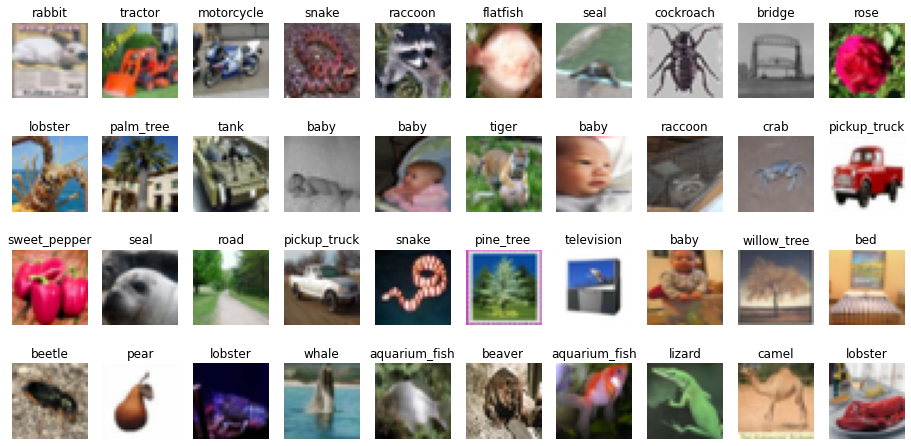

In [3]:
category_names = ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 
                  'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 
                  'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 
                  'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 
                  'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 
                  'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 
                  'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 
                  'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 
                  'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 
                  'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 
                  'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm']

def show(data, cols = 10, rows = 4):
    figure = plt.figure(figsize=(16, 8))
    to_PIL = ToPILImage()
    for i in range(1, cols * rows + 1):
        sample_idx = torch.randint(len(data), size=(1,)).item()
        img, label = data[sample_idx]                
        figure.add_subplot(rows, cols, i)
        plt.title(category_names[label])
        plt.axis("off")
        plt.imshow(to_PIL(img), cmap="gray")
    plt.show()

show(train_dataset, cols = 10, rows = 4)

## ConvNet as fixed feature extractor

In [4]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False
    

print(model_conv)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  